# Advanced ML: Домашнее задание 4

Николай Горев

Группа MADE-DS-22

In [1]:
import os
import numpy as np
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
corpora_path = 'corpora'
corpora_ru = list(open(os.path.join(corpora_path, 'WarAndPeace.txt'), encoding="utf-8")) + \
             list(open(os.path.join(corpora_path, 'AnnaKarenina.txt'), encoding="utf-8"))

**1.** Реализуйте базовый частотный метод по Шерлоку Холмсу:
- подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);
- возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе совсем вряд ли сработает), зашифруйте их посредством случайной перестановки символов;
- расшифруйте их таким частотным методом.

In [4]:
def buildNgrammDict(alphabet, corpora_data, ngramm_length=1):
    total_number = len(alphabet) ** ngramm_length
    freques = {''.join(ngramm) : 1 for ngramm in product(alphabet, repeat=ngramm_length)}
    
    for line in corpora_data:
        clean_line =''
        for symbol in line.lower():
            if symbol in alphabet:
                clean_line += symbol
        clean_line = ' '.join(clean_line.split())
        
        if len(clean_line) > 0:
            clean_line += ' '
            for i in range(len(clean_line) - ngramm_length + 1):
                ngramm = clean_line[i : i + ngramm_length]
                freques[ngramm] += 1
                total_number += 1

    for ngramm, freq in freques.items():
        freques[ngramm] = np.log(freq / total_number)
        
    return freques

alphabet_ru = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
freques_ru = buildNgrammDict(alphabet_ru, corpora_ru, ngramm_length=1)

In [5]:
# тестовый текст, на котором будем проверять алгоритмы
message = 'В течение многих часов Шерлок Холмс сидел  согнувшись  над ' +\
          'стеклянной  пробиркой,  в  которой  варилось что-то на редкость ' +\
          'вонючее. Голова его была опущена на грудь,  и  он  казался  мне ' +\
          'похожим  на  странную  тощую  птицу с тусклыми серыми перьями и ' +\
          'черным хохолком.'

In [6]:
# переведем в строчные буквы, удалим знаки препинания
cleared_message = ''
for symbol in message.lower():
    if symbol in alphabet_ru:
        cleared_message += symbol
test_message = ' '.join(cleared_message.split())
print(test_message)

в течение многих часов шерлок холмс сидел согнувшись над стеклянной пробиркой в которой варилось чтото на редкость вонючее голова его была опущена на грудь и он казался мне похожим на странную тощую птицу с тусклыми серыми перьями и черным хохолком


In [7]:
# шифрователь случайной перестановкой символов
class RandomPermuteCipher:
    def __init__(self, alphabet):
        self.alphabet = alphabet
        
        permutation = np.random.permutation(len(alphabet))
        self.cipher_dict = {}
        for i in range(len(alphabet)):
            self.cipher_dict[alphabet[i]] = alphabet[permutation[i]]

    def cipher(self, message):
        return ''.join([self.cipher_dict.get(symbol, '') for symbol in message])

In [8]:
def decipher(ciphered, decipher_dict):
    return ''.join([decipher_dict.get(symbol, '') for symbol in ciphered])

In [9]:
cipher = RandomPermuteCipher(alphabet_ru)

ciphered = cipher.cipher(test_message)
print(ciphered)

ъыэчхчеичыремщицыховмъысчбпмдыцмпрвывизчпывмщегъсив ыеозывэчдпнеемаыкбмтибдмаыъыдмэмбмаыъобипмв ыхэмэмыеоыбчздмвэ ыъмейхччыщмпмъоычщмытупоымкгшчеоыеоыщбгз ыиымеыдояопвныречыкмцмлирыеоывэбоеегйыэмшгйыкэиюгывыэгвдпуриывчбуриыкчб нриыиыхчбеурыцмцмпдмр


In [10]:
def getDecipherUnigramm(ciphered, freques_dict):
    text_symbols = list(set(ciphered))
    if len(text_symbols) < len(freques_dict):
        n_additional_symbols = len(freques_dict) - len(text_symbols)
        for symbol in freques_dict.keys():
            if symbol not in text_symbols:
                text_symbols.append(symbol)
                n_additional_symbols -= 1
                if n_additional_symbols == 0:
                    break
    
    freques = {symbol : 0 for symbol in text_symbols}
    for symbol in ciphered:
        freques[symbol] += 1

    freques = sorted([(letter, freq) for letter, freq in freques.items()], 
                     key=lambda p : p[1], reverse=True)
    
    corpusFreques = sorted([(letter, freq) for letter, freq in freques_dict.items()], 
                         key=lambda p : p[1], reverse=True)

    decipher_dict = {}
    for i in range(len(freques)):
        decipher_dict[freques[i][0]] = corpusFreques[i][0]
    
    return decipher_dict

In [11]:
decipher_dict = getDecipherUnigramm(ciphered, freques_ru)

In [12]:
decipher(ciphered, decipher_dict)

'д лапаеиа реогиь птнод йасвок ьоврн нибав ногемдйину етб нлаквжееоз ясошискоз д колосоз дтсивону плоло ет сабконлу доечпаа говодт аго шывт оямхает ет гсмбу и ое ктэтвнж реа яоьоцир ет нлстеемч лохмч ялиюм н лмнквыри насыри яасужри и пасеыр ьоьовкор'

In [13]:
# доля правильно расшифрованных букв
def decipherQuality(cipher_dict, decipher_dict):
    n_correct = 0
    for symbol in cipher_dict.keys():
        ciphered_symbol = cipher_dict[symbol]
        if ciphered_symbol in decipher_dict and symbol == decipher_dict[ciphered_symbol]:
            n_correct += 1
    return n_correct / len(decipher_dict)
    
decipherQuality(cipher.cipher_dict, decipher_dict)    

0.17647058823529413

**2.** Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг:
- подсчитайте частоты биграмм (т.е. пар последовательных букв) по корпусам;
- проведите тестирование аналогично п.1, но при помощи биграмм.

In [14]:
bigramm_logfreques_ru = buildNgrammDict(alphabet_ru, corpora_ru, ngramm_length=2)

In [15]:
# логарифм правдоподобия текста по частотам ngramm
def calculateNgrammLLH(ngramm_llh_dict):
    ngramm_length = len(list(ngramm_llh_dict.keys())[0])
    INFTY = 1e5
    def calculateLLH(text):
        llh = 0
        for i in range(len(text) - ngramm_length + 1):
            ngramm = text[i : i + ngramm_length]
            llh += ngramm_llh_dict.get(ngramm, -INFTY)
        return llh
    return calculateLLH

Для определения декодирующей перестановки поступим следующим образом:
- в качестве начального приближения возьмем декодирующую перестановку, полученную по частотам отдельных букв;
- будем последвательно улучшать декодирующую перестановку, пробуя переставлять пару случайных символов. В качестве критерия качества расшифровки берем логарифм правдоподобия расшифрованного текста, вычисленный по частотам биграмм.

In [16]:
def getDecipherBigramm(ciphered, calculateLLH, unigramm_dict):
    # начальное приближение - словарь по частотам отдельных букв
    decipher_dict = getDecipherUnigramm(ciphered, unigramm_dict)
    
    max_llh = calculateLLH(decipher(ciphered, decipher_dict))

    symbols = list(decipher_dict.keys())
    symbols_pairs = list(combinations(symbols, 2))
    
    # переставляем пары букв в словаре расшифровки и вычисляем 
    # логарифм правдоподобия по биграммам расшифрованного текста;
    # в случае улучшения правдоподобия запоминаем изменения
    improved = True
    while improved:
        improved = False
        for a, b in np.random.permutation(symbols_pairs):
            new_dict = decipher_dict.copy()
            new_dict[a], new_dict[b] = \
                new_dict[b], new_dict[a]
            llh = calculateLLH(decipher(ciphered, new_dict))
            if llh > max_llh:
                max_llh = llh
                decipher_dict = new_dict.copy()
                improved = True
                
    return decipher_dict

In [17]:
decipher_dict = getDecipherBigramm(ciphered, calculateNgrammLLH(bigramm_logfreques_ru), freques_ru)

In [18]:
decipher(ciphered, decipher_dict)

'з редение многив датоз желсок восмт тичес тогнузжить нач трексянной плобилкой з королой залисоть дроро на лечкотрь зонюдее госоза его быса опушена на глучь и он кахастя мне повофим на трланную рошую прицу т рутксыми телыми пельями и делным вовоском'

In [19]:
decipherQuality(cipher.cipher_dict, decipher_dict)

0.5294117647058824

**3.**	Но и это ещё не всё: биграммы скорее всего тоже далеко не всегда работают. Основная часть задания — в том, как можно их улучшить:
- предложите метод обучения перестановки символов в этом задании, основанный на MCMC-сэмплировании, но по-прежнему работающий на основе статистики биграмм;
- реализуйте и протестируйте его, убедитесь, что результаты улучшились

Используя MCMC-сэмплирование, построим последовательность дешифрующих перестановок символов, переставляя на каждом шаге пару символов. Считаем, что распределение перестановок пропорционально правдоподобию расшифрованного текста. Перестановку с лучшим правдоподобием сохраняем. Алгоритм похож на алгоритм из предыдущего пункта. Основное отличие: на каждой итерации не всегда происходит улучшение расшифровки, но, с некоторой вероятностью, допускается ухудшение. По-видимому, это позволяет иногда выйти из локального экстремума.

In [20]:
def getDecipherMCMC(ciphered, calculateLLH, unigramm_dict, steps=100):
    # начальное приближение - словарь по частотам отдельных букв
    decipher_dict = getDecipherUnigramm(ciphered, unigramm_dict)
    
    max_llh = calculateLLH(decipher(ciphered, decipher_dict))
    best_dict = decipher_dict.copy()
    
    prev_llh = max_llh

    symbols = list(decipher_dict.keys())
    symbols_pairs = list(combinations(symbols, 2))
    
    iteration = 0
    while iteration < steps:
        iteration += 1
        for a, b in np.random.permutation(symbols_pairs):
            new_dict = decipher_dict.copy()
            new_dict[a], new_dict[b] = new_dict[b], new_dict[a]
            llh = calculateLLH(decipher(ciphered, new_dict))
            if llh > prev_llh or random.random() < np.exp(llh - prev_llh):
                decipher_dict = new_dict.copy()
                prev_llh = llh

            if llh > max_llh:
                max_llh = llh
                best_dict = new_dict.copy()
                iteration = 0

    return best_dict

In [21]:
decipher_dict = getDecipherMCMC(ciphered, calculateNgrammLLH(bigramm_logfreques_ru), freques_ru)

In [22]:
decipher(ciphered, decipher_dict)

'в течение мнодиг часов шерлок голмс сизел соднувшись наз стеклянной пробиркой в которой варилось чтото на резкость вонючее долова едо была опужена на друзь и он кахался мне погофим на странную тожую птицу с тусклыми серыми перьями и черным гоголком'

In [23]:
decipherQuality(cipher.cipher_dict, decipher_dict)

0.7352941176470589

**4.** Расшифруйте сообщение:

←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨
⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌
⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛
↹↝←↹⇛↲←⇆⇴⇏

In [24]:
ciphered_final = '←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏'

In [25]:
len(ciphered_final)

230

In [26]:
random.seed(42)
np.random.seed(42)

decipher(
    ciphered_final, 
    getDecipherMCMC(
        ciphered_final, 
        calculateNgrammLLH(bigramm_logfreques_ru), 
        freques_ru
    )
)

'если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаж'

**5.** Бонус : а что если от биграмм перейти к триграммам (тройкам букв) или даже больше? Улучшатся ли результаты? Когда улучшатся, а когда нет? Чтобы ответить на этот вопрос эмпирически, уже может понадобиться погенерировать много тестовых перестановок и последить за метриками, глазами может быть и не видно.

In [27]:
trigramm_logfreques_ru = buildNgrammDict(alphabet_ru, corpora_ru, ngramm_length=3)

In [28]:
TRIALS = 100
bigramm_performance = []
trigramm_performance = []
for trial in range(TRIALS):
    cipher = RandomPermuteCipher(alphabet_ru)
    ciphered = cipher.cipher(test_message)
    decipher_dict_bigramm = getDecipherMCMC(ciphered, 
                                            calculateNgrammLLH(bigramm_logfreques_ru), 
                                            freques_ru)
    bigramm_performance.append(decipherQuality(cipher.cipher_dict, decipher_dict_bigramm))
    decipher_dict_trigramm = getDecipherMCMC(ciphered, 
                                             calculateNgrammLLH(trigramm_logfreques_ru), 
                                             freques_ru)
    trigramm_performance.append(decipherQuality(cipher.cipher_dict, decipher_dict_trigramm))

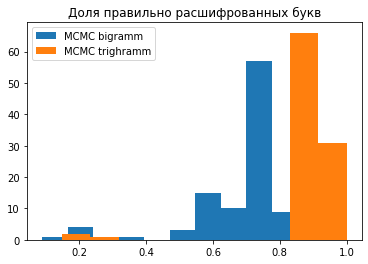

In [29]:
plt.hist(bigramm_performance, label='MCMC bigramm')
plt.hist(trigramm_performance, label='MCMC trighramm')
plt.legend()
plt.title('Доля правильно расшифрованных букв')
plt.show();

In [30]:
np.mean(bigramm_performance), np.mean(trigramm_performance)

(0.666764705882353, 0.8932352941176469)

Для нашего текста триграммы дают лучшую производительность. Попробуем на зашифрованном сообщении из предыдущего пункта.

In [31]:
random.seed(42)
np.random.seed(42)

decipher(
    ciphered_final, 
    getDecipherMCMC(
        ciphered_final, 
        calculateNgrammLLH(trigramm_logfreques_ru), 
        freques_ru
    )
)

'если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю'